**Cookie Cats Analysis**

This is an analysis project about A/B Testing on a game application called Cookie Cats. This game is available on every smartphone and everyone can play with it. This game application is one of simple games out there who has different levels with different stages. The player has to finish the previous gate before moving up to another level and gate.

The aim of this project is to find a comparison decision between 2 options related to the location of the gate in these available levels, either in level 30 or in level 40. A/B testing is used here to find that comparison. inside of this project, I used Chi-Square test, KDE in histogram, normality test, Bootstrap, and Mann-Whitney U test.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

### **Data Understanding**

In [ ]:
df = pd.read_csv('/content/cookie_cats.csv', sep=',')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### **Data Preparation**

In [ ]:
# Check for duplicate userid
df.duplicated(subset=['userid']).any()

False

In [ ]:
# Drop userid column as it is meaningless for this study
df.drop(columns=["userid"], inplace=True)

# Edit the version column
df.rename(columns={"version": "group"}, inplace=True)
df["group"] = np.where(df.group == "gate_30", "A", "B")
df.loc[:, "group"] = df.group.astype("category")

# Looks more organized now
df.head()

,group,sum_gamerounds,retention_1,retention_7
0,A,3,False,False
1,A,38,True,False
2,B,165,True,False
3,B,1,False,False
4,B,179,True,True


### **Exploratory Data Analysis**

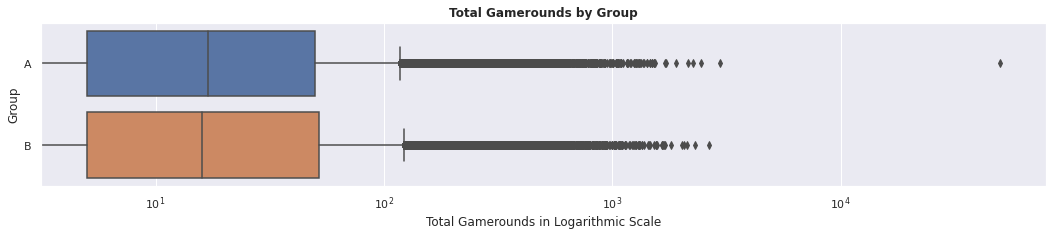

In [ ]:
# Total number of games distribution in log-scale
sns.set(rc={'figure.figsize':(18,3)})
ax=sns.boxplot(y = df.group, x = df.sum_gamerounds, orient="h")
ax.set_xscale('log')
plt.title("Total Gamerounds by Group", fontweight="bold")
plt.xlabel("Total Gamerounds in Logarithmic Scale")
plt.ylabel("Group")
plt.show()

In [ ]:
# Observe the outliers
df.sum_gamerounds.sort_values(ascending=False).head()

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
Name: sum_gamerounds, dtype: int64

In [ ]:
# Delete Outlier
df = df[df["sum_gamerounds"] < 3000].reset_index()

In [ ]:
# Check sum_gamerounds
df.sum_gamerounds.value_counts().head()

1    5538
2    4606
0    3994
3    3958
4    3629
Name: sum_gamerounds, dtype: int64

In [ ]:
# Those who never played games probably had no effect on the experiment
# Delete them as it will corrupt the statistics of the data
df = df[df.sum_gamerounds != 0].reset_index()

In [ ]:
# Describe the dataset
df['sum_gamerounds'].describe([0.95, 0.99])

count    86194.000000
mean        53.698297
std        104.425174
min          1.000000
50%         18.000000
95%        227.000000
99%        499.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

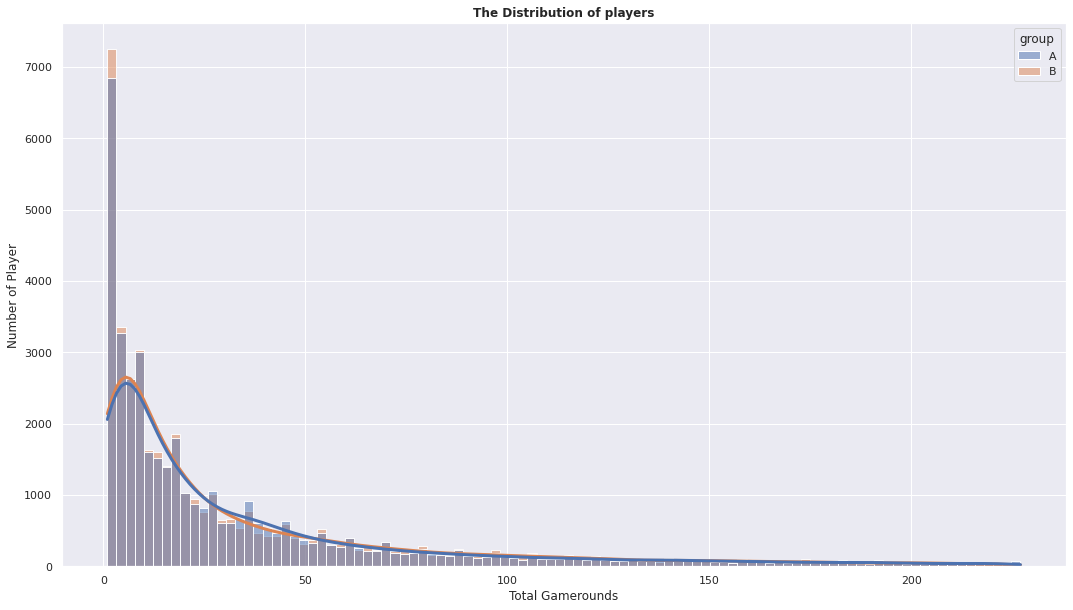

In [ ]:
# 95% of players have played 22 times or less. Draw them
sns.set(rc={'figure.figsize':(18,10)})
sns.histplot(data=df[df.sum_gamerounds<228], x="sum_gamerounds", kde=True,
             hue="group", line_kws={"lw":3}, bins=100)
plt.title("The Distribution of players", fontweight="bold")
plt.xlabel("Total Gamerounds")
plt.ylabel("Number of Player")
plt.show()

In [ ]:
# Function to check Sample Ratio Mismatch
def SRMcheck(df):
  num_A = df["group"].value_counts().loc["A"]
  num_B = df["group"].value_counts().loc["B"]

  print("Number of players in group A (gate_30):",num_A)
  print("Number of players in group B (gate_40):",num_B)
  print("A/B ratio: {:.5f}".format(num_A/num_B))
  print("-"*45)
    
  observed = [ num_A, num_B ]
  total_player= sum(observed)
  expected = [ total_player/2, total_player/2 ]

  chi = chisquare(observed, f_exp=expected)
  print("pvalue: {:.3f}".format(chi[1]))
  print("*"*15)
  if chi[1] < 0.01:
      print('SRM may be present.')
  else:
      print('Probably no SRM.')

In [ ]:
# Check SRM
SRMcheck(df)

Number of players in group A (gate_30): 42762
Number of players in group B (gate_40): 43432
A/B ratio: 0.98457
---------------------------------------------
pvalue: 0.022
***************
Probably no SRM.


### **Modelling & Evaluation : A/B Testing for Game Rounds**

In [ ]:
# Describe sum_gamerounds
df.groupby("group").sum_gamerounds.agg(["sum", "mean", "median"])

,sum,mean,median
group,,,
A,2294941,53.667766,18.0
B,2333530,53.728357,18.0


In [ ]:
# Check gamerounds difference

sum_difference= round(100*(df.query("group=='B'").sum_gamerounds.sum() - df.query("group=='A'").sum_gamerounds.sum()) 
      / df.query("group=='A'").sum_gamerounds.sum(), 2)
print("Group B played a total of {}% more games than group A".format(sum_difference))

Group B played a total of 1.68% more games than group A


**Data Distribution**

In [ ]:
# Function to check normality (Q-Q plot and Shapiro–Wilk test)

def checkNormality(df):
    sns.set(rc={'figure.figsize':(5,5)})
    sm.qqplot(df, line='45', fit=True)
    plt.show()

    _ , p= shapiro(df)
    alpha = 0.05
    print(f"p={p}")
    if p > alpha:
        print('Sample a normal distribution')
    else:
        print('Sample is not a normal distribution')

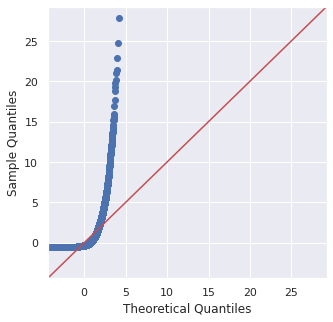

p=0.0
Sample is not a normal distribution


In [ ]:
# Check normality for sum_gamerounds

checkNormality(df.sum_gamerounds)

**Bootstrapping**

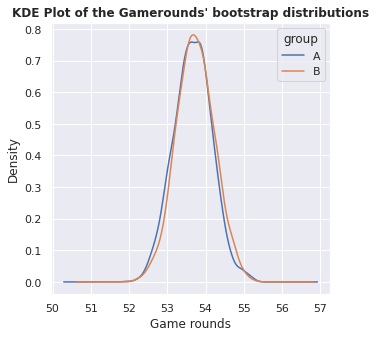

In [ ]:
# Bootstraping - Create 2000 samples of dataset

bootstrap_sum=pd.DataFrame([df.sample(frac=1, replace=True).groupby('group')['sum_gamerounds'].mean() for i in range(2000)])

bootstrap_sum.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the Gamerounds' bootstrap distributions", fontweight="bold")
plt.xlabel("Game rounds")
plt.show()

**H0 (Null hypothesis)** : Changing the gate level has no impact on sum_gamerounds

**H1 (Alternative hypothesis)**: Changing the gate level has an impact on sum_gamerounds

In [ ]:
# Function for Mann-Whitney U Test

def mannwhitneyfunc(value1,value2):

    stat, p=mannwhitneyu(sum_gamerounds1, sum_gamerounds2)

    alpha=0.05 

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two groups have no significant difference')
    else:
        print('Two groups have a significant difference')

In [ ]:
#Mann-Whitney U Test for sum_gamerounds

sum_gamerounds1 = df[df.group=='A'].sum_gamerounds
sum_gamerounds2 = df[df.group=='B'].sum_gamerounds

mannwhitneyfunc(sum_gamerounds1,sum_gamerounds2)

p=0.0588 , alpha=0.05 
Two groups have no significant difference


### **Modelling & Evaluation : A/B Testing for Retention Rates**

**H0 (Null hypothesis)** : Changing the gate level has no impact on retention rate

**H1 (Alternative hypothesis)**: Changing the gate level has an impact on retention rate

In [ ]:
# Retention rate by groups

retention_rate = df.groupby("group").agg({"retention_1":"mean","retention_7":"mean"})
retention_rate

,retention_1,retention_7
group,,
A,0.467541,0.198424
B,0.462171,0.190321


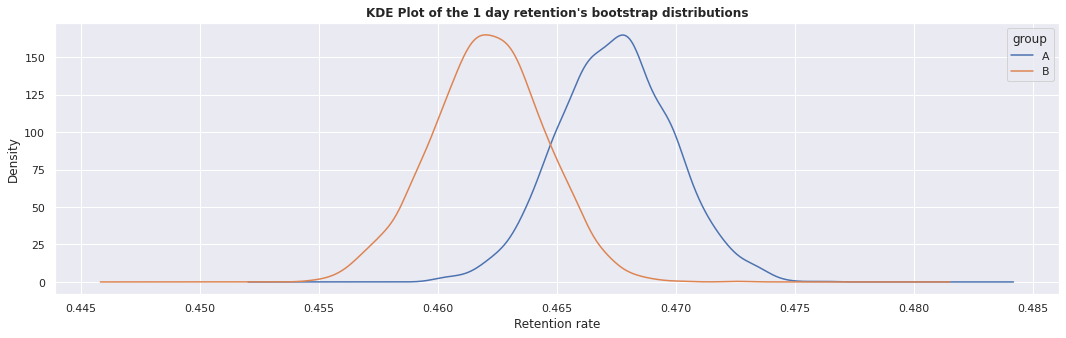

In [ ]:
# Bootstraping - Create 2000 samples of dataset for retention_1 

bootstrap_retention1=pd.DataFrame([df.sample(frac=1, replace=True).groupby('group')['retention_1'].mean() for i in range(2000)])

bootstrap_retention1.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the 1 day retention's bootstrap distributions", fontweight="bold")
plt.xlabel("Retention rate")
plt.show()

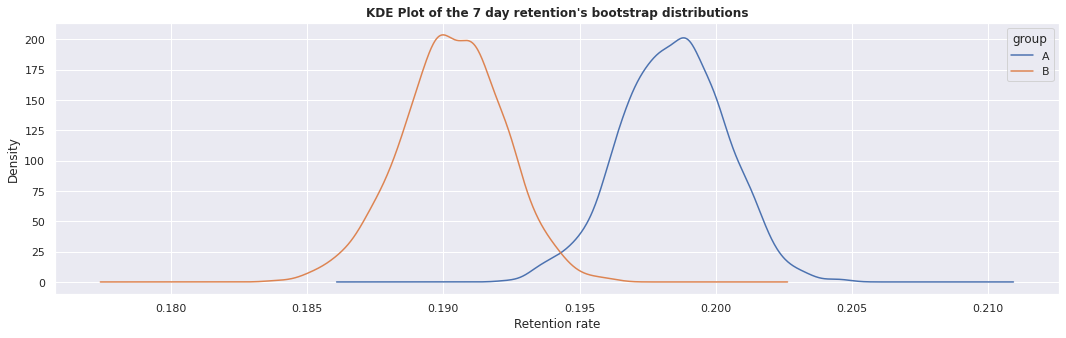

In [ ]:
# Bootstraping - Create 2000 samples of dataset for retention_7

bootstrap_retention7=pd.DataFrame([df.sample(frac=1, replace=True).groupby('group')['retention_7'].mean() for i in range(2000)])

bootstrap_retention7.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the 7 day retention's bootstrap distributions", fontweight="bold")
plt.xlabel("Retention rate")
plt.show()

In [ ]:
# Function for Chi-square test of independence of variables in a contingency table

def chi2test(df):
    _, p, _, _ = chi2_contingency(df)
    alpha = 0.05

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two groups have no significant difference')
    else:
        print('Two groups have a significant difference')

In [ ]:
#Chi-square test for retention_1 

cross1 = pd.crosstab(df["group"], df["retention_1"])
chi2test(cross1)

p=0.1155 , alpha=0.05 
Two groups have no significant difference


In [ ]:
#Chi-square test for retention_7

cross7 = pd.crosstab(df["group"], df["retention_7"])
chi2test(cross7)

p=0.0027 , alpha=0.05 
Two groups have a significant difference


## **Conclusion**

We discovered that the total number of game rounds in group B is slightly higher than the number of game rounds in group A. But the Mann-Whitney U Test shows that there is no statistically significant difference between the groups. So, we can say that changing the gate of the game from level 30 to level 40 has no effect on the game rounds played by the users.

We observed that retention rates were slightly higher in group A. According to the chi-square test, the 1-day user retention rates are not statistically different, but the 7-day user retention rate is higher in Group A. So, we can say that changing the gate of the game from level 30 to level 40 has negative effect on the 7-day user retention rate.

